# Hybrid: MT vs. HT 

In [1]:

import numpy as np
from homopy.elasticity import *
from homopy.methods import *
from homopy.stiffness_plot import *
from homopy.tensor import *

In [2]:
# define fiber and matrix properties for HT

# carbon (assuming isotropic fiber)
E_carbon = 242e9; G_carbon = 105e9; nu_carbon = 0.1; l_carbon = 1.5e-3; 
r_carbon = 7.2 / 2 * 1e-6; vol_carbon = 0.25; 

# glass (is isotropic)
E_glass = 80e9; nu_glass = 0.22; G_glass = 1/2*E_glass/(1+nu_glass); l_glass = 0.8e-3;
r_glass = 20 / 2 * 1e-6; vol_glass = 0.25

# PA6
E_pa6 = 1.18e9; nu_pa6 = 0.35; G_pa6 = 1/2*E_pa6/(1+nu_pa6); 


In [3]:
# define fiber and matrix properties for MT

# carbon 
carbon_fiber = Isotropy(E_carbon, nu_carbon)
v_frac_carbon = vol_carbon
a_carbon = l_carbon/(2*r_carbon)

# glass
glass_fiber = Isotropy(E_glass, nu_glass)
v_frac_glass = vol_glass
a_glass = l_glass/(2*r_glass)

# PA6
polyamid6 = Isotropy(E_pa6, nu_pa6)

In [4]:
# create HT and MT objects

ht_carbon = HalpinTsai(
        E_carbon,
        E_pa6,
        G_carbon,
        G_pa6,
        nu_carbon,
        nu_pa6,
        l_carbon,
        r_carbon,
        vol_carbon,
    )

ht_glass = HalpinTsai(
        E_glass,
        E_pa6,
        G_glass,
        G_pa6,
        nu_glass,
        nu_pa6,
        l_glass,
        r_glass,
        vol_glass,
    )


mt_hybrid = MoriTanaka(polyamid6, [carbon_fiber, glass_fiber], [v_frac_carbon/2, v_frac_glass/2], [a_carbon, a_glass], 2*['ellipsoid'])


In [5]:
# give n fibers a random distribtution and go from here

pi = np.pi
angle_disc = 1/40*pi # angle discretization
distribution = 'gauss'

# missuse ElasticPlot()
plotter = ElasticPlot()

n = 1000
theta = pi/2

def random_fibers(n, distribution = 'random', sigma = 0.1*pi, mean_angle=0):
    fiber_dirs = []
    angles = []
    for i in range(n):
        if distribution == 'random':
            phi = pi*np.random.rand() - pi/2 # equally likely -> isotropic
        elif distribution == 'gauss':
            phi = np.clip(np.random.normal(0, sigma), -pi/2, pi/2) # gaussian distribution -> change values to shift
        
        phi += mean_angle
        while np.any(phi>pi/2) or np.any(phi<-pi/2):
            if phi > pi/2:
                phi -= pi
            elif phi < -pi/2:
                phi += pi
            
        fiber_dirs.append(plotter._dir_vec(phi,theta))
        angles.append(phi)
    return np.array(fiber_dirs), angles
    
fiber_dirs_carbon, angles_carbon = random_fibers(n, distribution=distribution, sigma=0.1*pi)
fiber_dirs_glass, angles_glass = random_fibers(n, distribution=distribution, sigma= 0.2*pi)


# define function to calculate a discrete planar fiber distribution with a given angle spectrum

def get_distribution_histogram(angles, angle_disc):
    """
    Return the discrete orientation probability histogram for measured fiber_dirs.
    
    Paramters:
        - angles : array of shape (n,1)
            Measured fiber angles.
        - angle_spec : float in [0,pi]
            Angle spectrum.

    Returns:
        - angle_probs : ndarray of shape (pi/angle_spec, 1)
            Histogram of fiber orientation.
    """
    measurements = len(angles)
    angle_probs = []
    for i in np.arange(-pi/2-angle_disc/2,pi/2, angle_disc):
        # print("[{}, {}, {}]".format(i, i+angle_spec/2, i + angle_spec))
        hits = 0
        for angle in angles:
            if angle > i and angle <= i + angle_disc:
                hits += 1
        angle_probs.append([i+angle_disc/2,hits/measurements])
    return angle_probs
            
            

hist_carbon = np.array(get_distribution_histogram(angles_carbon, angle_disc))
hist_glass = np.array(get_distribution_histogram(angles_glass, angle_disc))
    

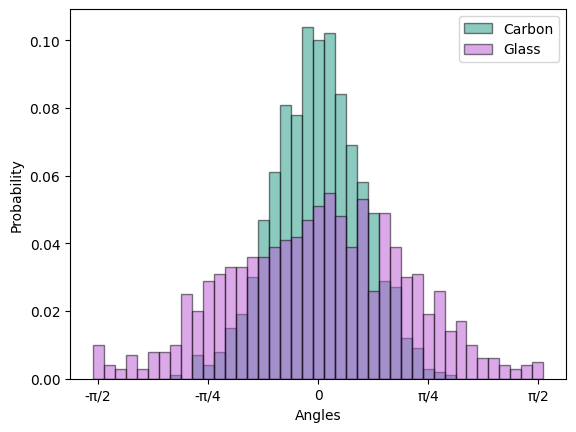

In [6]:
# plot angle distribution

import matplotlib.pyplot as plt

x_carbon = hist_carbon[:,0]
y_carbon = hist_carbon[:,1]

x_glass = hist_glass[:,0]
y_glass = hist_glass[:,1]

plt.bar(x_carbon,y_carbon,width=angle_disc,align='center', color=(27/256,151/256,131/256),edgecolor='k', alpha=0.5, label='Carbon')
plt.bar(x_glass,y_glass,width=angle_disc,align='center', color='mediumorchid',edgecolor='k', alpha=0.5, label='Glass')
plt.xlabel('Angles')
plt.ylabel('Probability')
plt.xticks(np.arange(-pi/2, pi/2+pi/4, step=(pi/4)), ['-π/2','-π/4', '0', 'π/4','π/2'])


plt.legend()
plt.show()


In [7]:
# build orientation tensor of 4th and 2nd order

def get_N(fiber_dirs):
    N4 = np.zeros((3,3,3,3))
    for fiber_dir in fiber_dirs:
        N4 += np.einsum('i,j,k,l->ijkl', fiber_dir, fiber_dir, fiber_dir, fiber_dir)
    N4 /= len(fiber_dirs)
    N2 = np.einsum('ijkk->ij', N4)
    return N2, N4


N2_carbon, N4_carbon = get_N(fiber_dirs_carbon)
N2_glass, N4_glass = get_N(fiber_dirs_glass)
    

In [8]:
"""
from fiberoripy.closures import (
    IBOF_closure,
    get_random_tensor_pair,
    hybrid_closure,
    linear_closure,
    quadratic_closure,
)
from fiberoripy.tensorplot import (
    plot_orbit2,
    plot_orbit4,
    plot_projection2,
    plot_projection4,
)

# graphical representation of orientation tensors of 4th order

N4_carbon_flat = Tensor().tensor2mandel(N4_carbon)
N4_glass_flat = Tensor().tensor2mandel(N4_glass)

N2 = np.zeros((3,3))
N2[0,0] = 9/10
N2[1,1] = 1/20
N2[2,2] = 1/20
N4 = Tensor().tensor2mandel(IBOF_closure(N2))

_ = plotter.plot_E_body(np.linalg.inv(N4_carbon_flat), 200, 200, bound=[0.5,0.5,0.5])
"""
pass

In [9]:
# average MT

mt_hybrid_ave = mt_hybrid.get_average_stiffness([N2_carbon, N2_glass], [N4_carbon, N4_glass], method='benveniste')

# build laminate from HT results

laminas_carbon = len(angles_carbon)*[ht_carbon.get_effective_stiffness()]
laminas_glass = len(angles_glass)*[ht_glass.get_effective_stiffness()]

laminas_combined = laminas_carbon + laminas_glass
angles_combined = angles_carbon + angles_glass

ht_laminate = Laminate(laminas_combined, angles_combined)

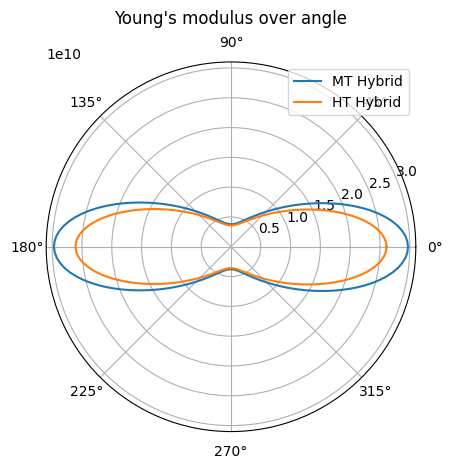

In [10]:
# Compare MT and HT after orientation averaging

# mt_hybrid_plot = plotter.polar_plot_E_body(np.linalg.inv(mt_hybrid.effective_stiffness66), 200, 0, plot=True)


mt_hybrid_plot_ave = plotter.polar_plot_E_body(np.linalg.inv(mt_hybrid_ave), 200, 0, plot=False)
ht_hybrid_plot_ave = plotter.polar_plot_laminate(ht_laminate.get_effective_stiffness(), 1000, plot=False)


plotter.polar_plot(
    [mt_hybrid_plot_ave + ("MT Hybrid",), ht_hybrid_plot_ave + ("HT Hybrid",)]
) 

In [11]:
"""
This is an interactive plot to show how the fiber distributions of each constituent
affects the effective porperties. Open in jupyter notebook to get full interaction
support. We recommend using the option Cell -> Current Outputs -> Toggle
"""
"""
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt

x_carbon = hist_carbon[:,0]
y_carbon = hist_carbon[:,1]

x_glass = hist_glass[:,0]
y_glass = hist_glass[:,1]

fig = plt.figure(figsize=(6,6))
ax1 = plt.subplot(311)
ax1.set_ylim([0, 0.2])


line1 = ax1.bar(x_carbon,y_carbon,width=angle_disc,align='center', color=(27/256,151/256,131/256),edgecolor='k', alpha=0.5, label='Carbon')
line2 = ax1.bar(x_glass,y_glass,width=angle_disc,align='center', color='mediumorchid',edgecolor='k', alpha=0.5, label='Glass')

plt.legend()

ax1.set_xlabel('Angles')
ax1.set_ylabel('Probability')
ax1.set_xticks(np.arange(-pi/2, pi/2+pi/4, step=(pi/4)), ['-π/2','-π/4', '0', 'π/4','π/2'])

ax2 = plt.subplot(212, projection='polar')
ax2.set_ylim([0,4e10])

line3, = ax2.plot(mt_hybrid_plot_ave[0], mt_hybrid_plot_ave[1], label='MT Hybrid')
line4, = ax2.plot(ht_hybrid_plot_ave[0], ht_hybrid_plot_ave[1], label='HT Hybrid')

plt.legend()

    
@interact(sig_c = (0,0.3,0.01), dist_c=["random", "gauss"], sig_g = (0,0.3,0.01), dist_g=["random", "gauss"], n=fixed(1000),
         angle_disc=fixed(1/40*np.pi))
def update_fiber_dist(sig_c=0.1, dist_c = 'gauss', sig_g=0.2, dist_g = 'gauss', n=1000, angle_disc=1/40*np.pi):
 
    fibers_carbon, angles_carbon = random_fibers(n, distribution=dist_c, sigma=sig_c*pi)
    hist_carbon = np.array(get_distribution_histogram(angles_carbon, angle_disc=angle_disc))
    x_carbon = hist_carbon[:,0]
    y_carbon = hist_carbon[:,1]
    i = 0
    for rect, h in zip(line1, x_carbon):
        rect.set_height(y_carbon[i])
        i += 1
        
    fibers_glass, angles_glass = random_fibers(n, distribution=dist_g, sigma=sig_g*pi)
    hist_glass = np.array(get_distribution_histogram(angles_glass, angle_disc=angle_disc))
    x_glass = hist_glass[:,0]
    y_glass = hist_glass[:,1]
    i = 0
    for rect, h in zip(line2, x_glass):
        rect.set_height(y_glass[i])
        i += 1
        
    
    N2_carbon, N4_carbon = get_N(fibers_carbon)
    N2_glass, N4_glass = get_N(fibers_glass)
    
    mt_hybrid_ave = mt_hybrid.get_average_stiffness((N2_carbon+N2_glass)/2, (N4_carbon+N4_glass)/2)

    laminas_carbon = len(angles_carbon)*[ht_carbon.get_effective_stiffness()]
    laminas_glass = len(angles_glass)*[ht_glass.get_effective_stiffness()]

    laminas_combined = laminas_carbon + laminas_glass
    angles_combined = angles_carbon + angles_glass

    ht_laminate = Laminate(laminas_combined, angles_combined)
    
    mt_hybrid_plot_ave = plotter.polar_plot_E_body(np.linalg.inv(mt_hybrid_ave), 200, 0, plot=False)
    ht_hybrid_plot_ave = plotter.polar_plot_laminate(ht_laminate.get_effective_stiffness(), 1000, plot=False)
        
    line3.set_ydata(mt_hybrid_plot_ave[1])
    line4.set_ydata(ht_hybrid_plot_ave[1])
        
    fig.canvas.draw_idle()
"""
pass

In [12]:
"""
Same plot as above, just with %matplotlib inline.
The reason for this is that %matplotlib notebook does not seem to be working with
binder currently. The above version is kept, because it looks a bit more crispy...

This is an interactive plot to show how the fiber distributions of each constituent
affects the effective porperties. Open in jupyter notebook to get full interaction
support. We recommend using the option Cell -> Current Outputs -> Toggle
"""

%matplotlib inline
%config InlineBackend.figure_format = 'svg' # makes everything super crispy
from ipywidgets import *
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


def update_fiber_dist(sig_c=0.1, dist_c = 'gauss', sig_g=0.2, dist_g = 'gauss', 
                      vol_c=0.25, vol_g=0.25, mean_angle_c=0, mean_angle_g=0,
                      n=1000, angle_disc=1/40*np.pi):
    
    ht_carbon = HalpinTsai(
        E_carbon,
        E_pa6,
        G_carbon,
        G_pa6,
        nu_carbon,
        nu_pa6,
        l_carbon,
        r_carbon,
        vol_c,
    )

    ht_glass = HalpinTsai(
        E_glass,
        E_pa6,
        G_glass,
        G_pa6,
        nu_glass,
        nu_pa6,
        l_glass,
        r_glass,
        vol_g,
    )
    
    mt_hybrid = MoriTanaka(polyamid6, [carbon_fiber, glass_fiber], [vol_c/2, vol_g/2],
                           [a_carbon, a_glass], 2*['ellipsoid'])
    
    fibers_carbon, angles_carbon = random_fibers(n, distribution=dist_c, sigma=sig_c*pi, mean_angle=mean_angle_c)
    hist_carbon = np.array(get_distribution_histogram(angles_carbon, angle_disc=angle_disc))
    x_carbon = hist_carbon[:,0]
    y_carbon = hist_carbon[:,1]
        
    fibers_glass, angles_glass = random_fibers(n, distribution=dist_g, sigma=sig_g*pi, mean_angle=mean_angle_g)
    hist_glass = np.array(get_distribution_histogram(angles_glass, angle_disc=angle_disc))
    x_glass = hist_glass[:,0]
    y_glass = hist_glass[:,1]
        
    N2_carbon, N4_carbon = get_N(fibers_carbon)
    N2_glass, N4_glass = get_N(fibers_glass)
    
    mt_hybrid_ave = mt_hybrid.get_average_stiffness([N2_carbon, N2_glass], [N4_carbon, N4_glass], method='benveniste')

    laminas_carbon = len(angles_carbon)*[ht_carbon.get_effective_stiffness()]
    laminas_glass = len(angles_glass)*[ht_glass.get_effective_stiffness()]

    laminas_combined = laminas_carbon + laminas_glass
    angles_combined = angles_carbon + angles_glass

    ht_laminate = Laminate(laminas_combined, angles_combined)
    
    mt_hybrid_plot_ave = plotter.polar_plot_E_body(np.linalg.inv(mt_hybrid_ave), 200, 0, plot=False)
    ht_hybrid_plot_ave = plotter.polar_plot_laminate(ht_laminate.get_effective_stiffness(), 1000, plot=False)
        
        
    fig = plt.figure(figsize=(6,6))
    ax1 = plt.subplot(311)
    ax1.set_ylim([0, 0.2])


    line1 = ax1.bar(x_carbon,y_carbon,width=angle_disc,align='center', color=(27/256,151/256,131/256),edgecolor='k', alpha=0.5, label='Carbon')
    line2 = ax1.bar(x_glass,y_glass,width=angle_disc,align='center', color='mediumorchid',edgecolor='k', alpha=0.5, label='Glass')

    plt.legend()

    ax1.set_xlabel('Angles')
    ax1.set_ylabel('Probability')
    ax1.set_xticks(np.arange(-pi/2, pi/2+pi/4, step=(pi/4)), ['-π/2','-π/4', '0', 'π/4','π/2'])

    ax2 = plt.subplot(212, projection='polar')
    ax2.set_ylim([0,6e10])

    line3, = ax2.plot(mt_hybrid_plot_ave[0], mt_hybrid_plot_ave[1], label='MT Hybrid')
    line4, = ax2.plot(ht_hybrid_plot_ave[0], ht_hybrid_plot_ave[1], label='HT Hybrid')

    plt.legend()


sig_c = widgets.FloatSlider(value=0.1, min=0.0, max=0.3, step=0.01, description='SD carb.:',
                           layout=Layout(width='250px'))
sig_g = widgets.FloatSlider(value=0.1,min=0.0, max=0.3, step=0.01, description='SD glass:',
                           layout=Layout(width='250px'))
mean_angle_c = widgets.FloatSlider(value=0.0, min=-np.pi/2, max=np.pi/2, step=np.pi/16, description='Mean angle carb.:',
                           layout=Layout(width='250px'), style = {'description_width': 'initial'})
mean_angle_g = widgets.FloatSlider(value=0.0, min=-np.pi/2, max=np.pi/2, step=np.pi/16, description='Mean angle glass:',
                           layout=Layout(width='250px'), style = {'description_width': 'initial'})
dist_c = widgets.Dropdown(options=['gauss', 'random'],
    value='gauss',
    disabled=False,
    description='Dist. carb.:',
    layout=Layout(width='180px')
)
dist_g = widgets.Dropdown(options=['gauss', 'random'],
    value='gauss',
    disabled=False,
    description='Dist. glass:',
    layout=Layout(width='180px')
)
vol_frac_c = widgets.BoundedFloatText(
    value=0.25,
    min=0,
    max=1,
    step=0.01,
    description='v_frac carb.:',
    disabled=False,
    layout=Layout(width='150px')
)
vol_frac_g = widgets.BoundedFloatText(
    value=0.25,
    min=0,
    max=1,
    step=0.01,
    description='v_frac glass:',
    disabled=False,
    layout=Layout(width='150px')
)

HBox_carbon = widgets.HBox([sig_c,dist_c,vol_frac_c,mean_angle_c])
HBox_glass = widgets.HBox([sig_g,dist_g,vol_frac_g,mean_angle_g])
ui = widgets.VBox([HBox_carbon, HBox_glass])

out = widgets.interactive_output(update_fiber_dist, {'sig_c': sig_c, 'dist_c': dist_c, 'sig_g': sig_g,
                                                    'dist_g': dist_g, 'vol_c': vol_frac_c,
                                                    'vol_g': vol_frac_g, 'mean_angle_c': mean_angle_c,
                                                    'mean_angle_g': mean_angle_g})

display(out, ui)

Output()